# 计算机图形学 第三次实验

Code / Writeup by: William Wei / 魏铼

## Python 中实现 GeoJSON 绘图

使用 [DataV.GeoAtlas](https://datav.aliyun.com/portal/school/atlas/area_selector) 工具下载 GeoJSON，结合 GeoPandas / Matplotlib 即可轻松完成。

Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


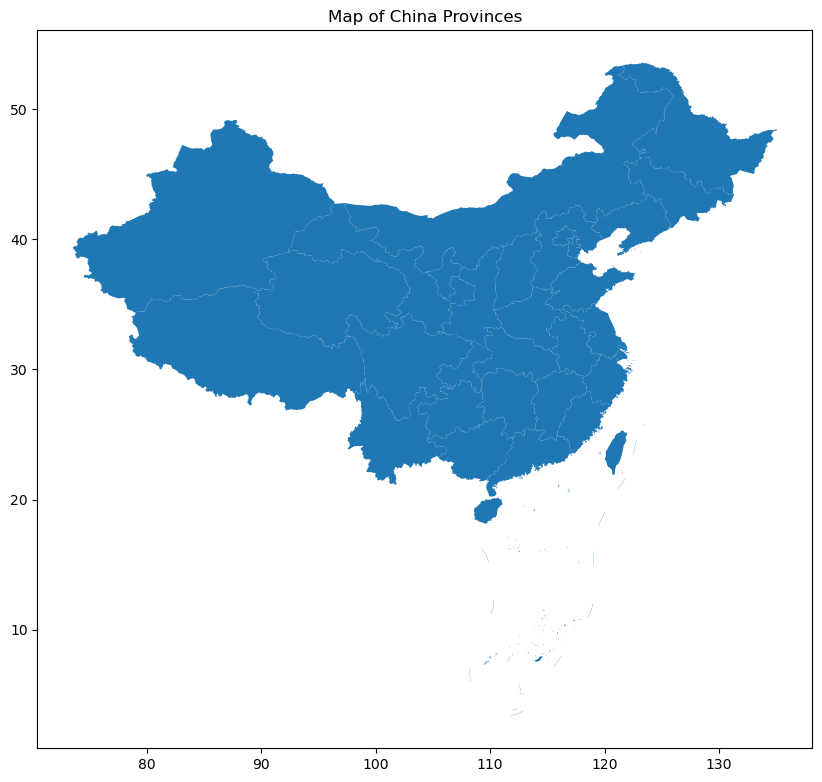

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file('resources/china.geojson')

gdf.plot(figsize=(10, 10))
plt.title('Map of China Provinces')
plt.show()

## 压缩算法

### Douglas-Peucker 简化

了解到 `geopandas` 使用 `shapely` 作为几何处理工具，而 `shapely` 自带 `simplify` 方法，其正好使用了 Douglas-Peucker 算法，我们将采用这个方法简化。

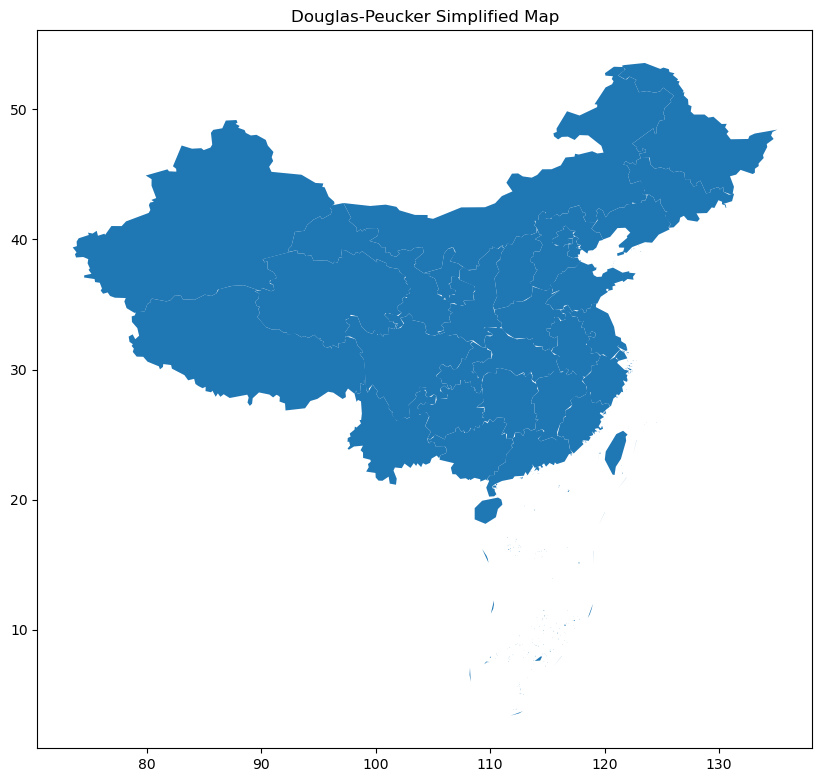

In [2]:
tolerance_dp = 0.1   # 以度为单位的容差值，这里设置相对大的值，以便看到差别
gdf_dp = gdf.copy()  # 创建一个新的 GeoDataFrame 用于存储简化后的数据
gdf_dp['geometry'] = gdf['geometry'].simplify(tolerance_dp, preserve_topology=True)

gdf_dp.plot(figsize=(10, 10))
plt.title('Douglas-Peucker Simplified Map')
plt.show()

### Visvalingam-Whyatt 简化

在搜集网络资源时，我们发现了另一个名为 Visvalingam-Whyatt 的算法。使用 `simplification` 库可以快速应用这种算法。但是该方法只能接受**点对**，因此我们需要一些转换代码，将 GeoJSON 转换为 `shapely` 几何实例。

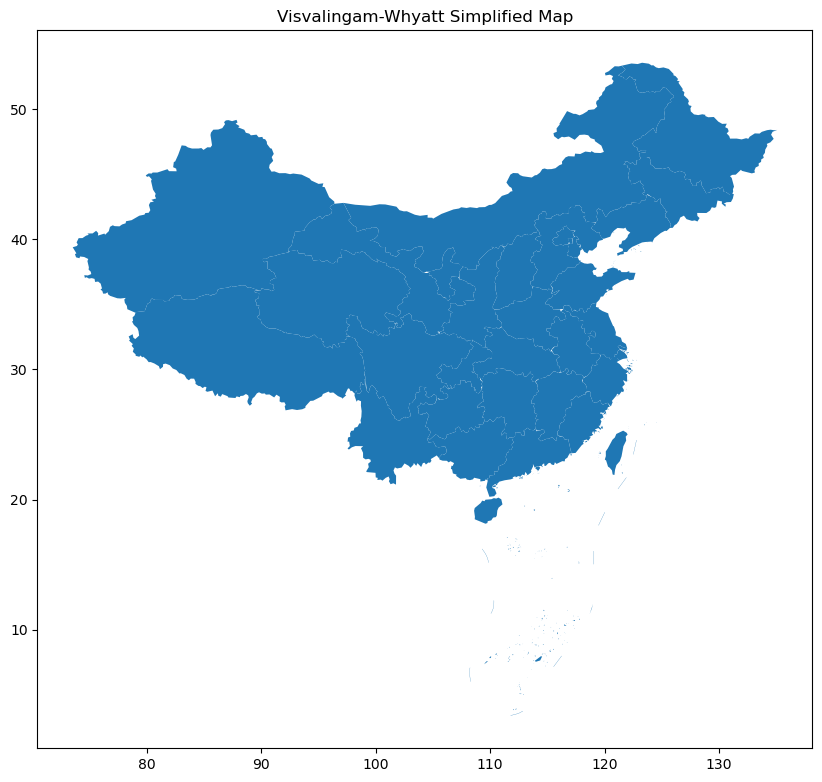

In [3]:
from simplification.cutil import simplify_coords_vw
from shapely.geometry import Polygon, MultiPolygon, LinearRing

def simplify_ring_vw(ring, tolerance):
    coords = list(ring.coords)
    simplified_coords = simplify_coords_vw(coords, tolerance)
    
    if len(simplified_coords) < 4:
        return ring
    
    return LinearRing(simplified_coords)

def simplify_polygon_vw(poly, tolerance):
    exterior = simplify_ring_vw(poly.exterior, tolerance)
    interiors = [simplify_ring_vw(interior, tolerance) for interior in poly.interiors]
    return Polygon(exterior, interiors)

def simplify_multipolygon_vw(mpoly, tolerance):
    simplified_polys = [simplify_polygon_vw(poly, tolerance) for poly in mpoly.geoms]
    return MultiPolygon(simplified_polys)

def simplify_geometry_vw(geom, tolerance):
    if geom.geom_type == 'Polygon':
        return simplify_polygon_vw(geom, tolerance)
    elif geom.geom_type == 'MultiPolygon':
        return simplify_multipolygon_vw(geom, tolerance)
    else:
        raise ValueError("Unsupported geometry type: {}".format(geom.geom_type))

tolerance_vw = 0.01  # 以平方度为单位的容差值，这里设置相对大的值，以便看到差别
gdf_vw = gdf.copy()
gdf_vw['geometry'] = gdf['geometry'].apply(lambda geom: simplify_geometry_vw(geom, tolerance_vw))

gdf_vw.plot(figsize=(10, 10))
plt.title('Visvalingam-Whyatt Simplified Map')
plt.show()

我们来比较一下吧！

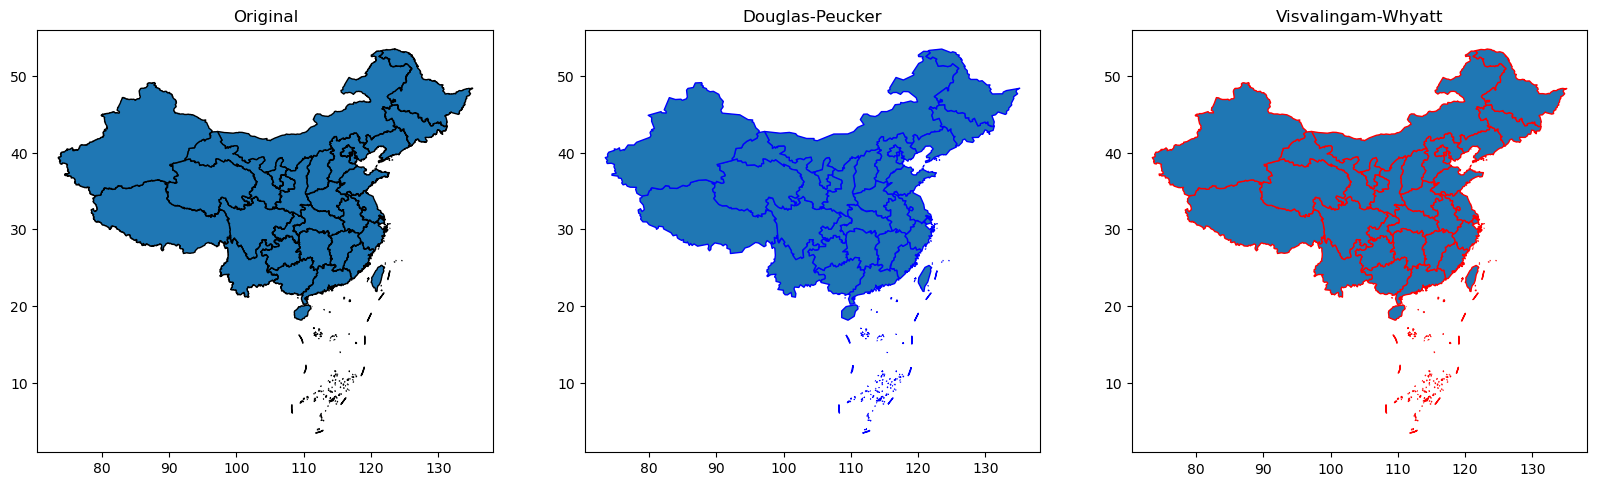

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# 原始
gdf.plot(ax=axes[0], edgecolor='black')
axes[0].set_title('Original')

# Douglas-Peucker
gdf_dp.plot(ax=axes[1], edgecolor='blue')
axes[1].set_title('Douglas-Peucker')

# Visvalingam-Whyatt
gdf_vw.plot(ax=axes[2], edgecolor='red')
axes[2].set_title('Visvalingam-Whyatt')

plt.show()

对于这种大范围的压缩，我们可以看到两种算法的压缩都很不错，基本看不出差别。我们随便拿一个行政区仔细比较一下。这里不用专门的 GeoJSON 文件了，直接取数列的第一个。

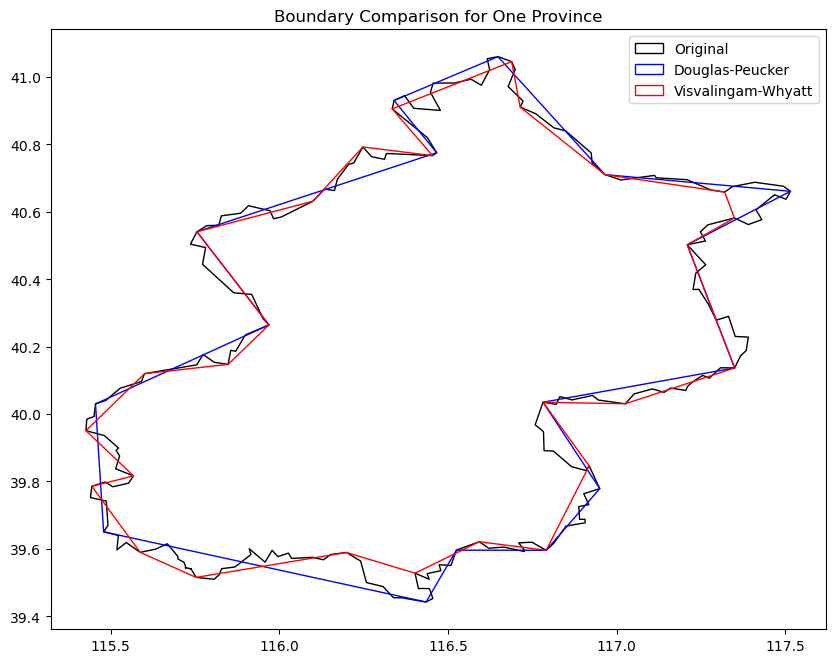

In [5]:
from matplotlib.patches import Patch

province = gdf.iloc[0]
province_dp = gdf_dp.iloc[0]
province_vw = gdf_vw.iloc[0]

fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoSeries([province['geometry']]).plot(ax=ax, color='none', edgecolor='black')
gpd.GeoSeries([province_dp['geometry']]).plot(ax=ax, color='none', edgecolor='blue')
gpd.GeoSeries([province_vw['geometry']]).plot(ax=ax, color='none', edgecolor='red')

legend_handles = [
    Patch(edgecolor='black', facecolor='none', label='Original'),
    Patch(edgecolor='blue', facecolor='none', label='Douglas-Peucker'),
    Patch(edgecolor='red', facecolor='none', label='Visvalingam-Whyatt')
]
ax.legend(handles=legend_handles)

plt.title('Boundary Comparison for One Province')
plt.show()

抽到了**北京市**。

可以看到 **Douglas 算法会保留折线中转折比较大的点，Visvalingam 算法则是考虑面积一致性，让图线变得更平滑**。

In [7]:
def count_points(geom):
    if geom.geom_type == 'Polygon':
        return len(geom.exterior.coords) + sum(len(interior.coords) for interior in geom.interiors)
    elif geom.geom_type == 'MultiPolygon':
        return sum(count_points(poly) for poly in geom.geoms)
    else:
        return 0

total_points_original = gdf['geometry'].apply(count_points).sum()
total_points_dp = gdf_dp['geometry'].apply(count_points).sum()
total_points_vw = gdf_vw['geometry'].apply(count_points).sum()

print(f"原始点数: {total_points_original}")
print(f"Douglas-Peucker 压缩后: {total_points_dp}")
print(f"Visvalingam-Whyatt 压缩后: {total_points_vw}")

原始点数: 25240
Douglas-Peucker 压缩后: 3594
Visvalingam-Whyatt 压缩后: 5399


在相同的容差值下（认为 0.1 度相当于 0.01 平方度），Douglas 算法压缩了更多点。

> 注：不知道这样比较是否合适。不合适还请批评指正。

我们总结一下两种算法的区别。

在核心原理上：

| **特征**                | **Douglas-Peucker**                     | **Visvalingam-Whyatt**                 |
|-------------------------|-----------------------------------------|-----------------------------------------|
| **评估标准**            | 基于点到基准线的垂直距离                | 基于相邻三点构成三角形的面积            |
| **迭代方式**            | 递归分割线段，保留最大偏差点            | 逐步移除对形状影响最小的点（最小面积）  |
| **参数意义**            | 距离阈值（ε）：允许的最大垂直误差       | 面积阈值（或保留点数）：移除最不重要的点|

在效果上：

| **特性**                | **Douglas-Peucker**                     | **Visvalingam-Whyatt**                 |
|-------------------------|-----------------------------------------|-----------------------------------------|
| **形状保持**            | 保留尖锐拐角，适合人造特征（如道路）    | 保持区域重要性，适合自然特征（如河流）  |
| **简化结果**            | 可能忽略小波动，但保留显著转折点        | 更均匀简化，减少局部细节但维持整体形态  |
| **参数敏感性**          | 对距离阈值敏感，易控制局部误差          | 对面积阈值敏感，需调整以平衡全局特征    |

### **总结**

- **Douglas-Peucker** 以距离为核心，适合保留显著特征；  
- **Visvalingam-Whyatt** 以面积为度量，适合维持整体形态。  